# Decision Trees #

Decision trees are like flowcharts, containing different decision points, which you follow down until you eventually get to a final node (with no more branches following it, called a *leaf*) providing the final decision.

A classification decision tree is constructed by continually splitting the data points according to features until we can classify the data points with labels as the leaves. This is best explained with an example so consider 4 training data points each with 2 features and labeled as \[0, 1\]:

| index | $x_1$ | $x_2$ | y |
| ------- | ------- | ------- | -------|
| 0 | Y | N | 1 |
| 1 | Y | Y | 1 |
| 2 | N | Y | 0 |
| 3 | N | N | 1 |

For example, given these data points, we could constuct the following:

First, we can split the data on the setting of the first feature, $x_1$. We see that all data points with $x_1$ == *Y* have the same labels, while those set to *N*. So we get:

* if $x_1$ == Y: label data as y=1
* if $x_1$ == N: need to look at feature $x_2$

Second, we can create another branch coming off of $x_1$ == N, because the training data in this case leads to different classes. For these two data points, the $x_2$ feature helps differentiate these data points. This means:

* if $x_1$ == N and $x_2$ == Y: label data as y=0
* if $x_1$ == N and $x_2$ == N: label data as y=1

This is a small illustrative example of how we can split data points in the "flow chart" sort of way. In the decision tree algorithm, the actual decision on features to split on is decided by measuring the quality of the split for different features. There are several measures that can be used including Gini impurity (scikit-learn default) and information gain measured by entropy or log loss.

Gini:
<center>$G(D) = 1 - \sum_{i=1}^k p_i^2 $</center>

where $p_i$ is the probability of a data point belonging to class $i$ for training subset D. The split should be selected to minimize the Gini impurity value. Using the example table above, the Gini impurity value is calculated at the beginning to determine which feature should be the initial split:

| split | count *y=0* | count *y=1* | $p_{y=0}$ | $p_{y=1}$ | Gini |
| ------- | ------- | -------- | ------- | -------- | ------- |
| $x_1$ | 1 | 3 | 0.25 | 0.75 | $1$-$0.25^2$-$0.75^2$ = 0.375 |
| $x_2$ | 1 | 3 | 0.25 | 0.75 | $1$-$0.25^2$-$0.75^2$ = 0.375 |

In this case, either feature would be possible to split (equal Gini values). This can be seen when looking at the data set, as starting with either feature and following up with the second allows for the data to be segmented by the label.

##### Overfitting #####

It's worth noting a similar split for the $x_2$ branch would not be likely to include in the final model for a larger data set. This is because with such few data points being split here, we would worry about overfitting ot the training set. For this reason, decision trees are often implemented with a maximum size (maximum length from first, aka root node, to the leaf on the longest path). Alternatively, *pruning* after the fact can also be used to remove branches deemed less important for classification, for example branches with small training point samples or storing redundant information.

In [64]:
# import packages
from sklearn import datasets, model_selection, metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

import numpy as np
import matplotlib.pyplot as plt

### Import Data ###

Import the built-in wine data set with 3 classes and 13 features. I will split the data into the training and testing sets. In this case, I will attempt to combat overfitting by setting a maximum depth of the tree. Instead of using a specified validation set for this parameter tuning, I'll use cross-validation instead. Specifically, I'll divide the training set into 5 subgroups, so that each time I can train on 4 subgroups and 1 will function as the validation set, iterating through all 5 subgroups as the validation set. This allows for a greater amount of training data to be used and makes it harder to overfit the parameter choice to the validation set.

In [52]:
data = datasets.load_wine()
X = data['data']
Y = data['target']

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y, train_size=0.7)
# implement Kfold with stratified to balance the folds wrt the different classes
strat_kfold = model_selection.StratifiedKFold()
splits = strat_kfold.split(X_train, Y_train)

### Create Model ###

Use the training data folds to train and test the model for different depth values. For each depth value, we'll find the average performance (measured by accuracy) of the trained model for each fold as the validation set. Then, using this information we can decide the correct depth that should be used to avoid overfitting but construct a fairly good classification model.

In [53]:
depths = np.arange(1, 14)
avg_accs = np.zeros(len(depths))

for train,val in splits:
    # get training and validation sets for this fold set from the training data set
    train_set = X_train[train,:]
    train_label = Y_train[train]
    val_set = X_train[val,:]
    val_label = Y_train[val]
    
    # for each validation set, build a tree with each max depth
    for d in range(len(depths)):
        model = DecisionTreeClassifier(max_depth=depths[d])
        model.fit(train_set, train_label)
        acc = model.score(val_set, val_label)
        avg_accs[d] += acc

avg_accs = avg_accs/5

for i in range(len(depths)):
    print(depths[i], ':', avg_accs[i])

1 : 0.6133333333333334
2 : 0.8303333333333333
3 : 0.8386666666666667
4 : 0.8626666666666667
5 : 0.8866666666666667
6 : 0.8706666666666667
7 : 0.8626666666666667
8 : 0.8466666666666667
9 : 0.8783333333333333
10 : 0.8703333333333333
11 : 0.8783333333333333
12 : 0.8546666666666667
13 : 0.8703333333333333


From the above results, it seems that a depth of 5 performs the best. Note though, that this is dependent on the average performance across each fold being the validation set, with the others being used to train the model. All the data set splitting from the initial training/testing split to the $k$ folds is random, so this is subject change. Over several runs, I've found performance is good beginning around a depth of 3 or later. 

Generally we want to avoid overfitting, which deeper trees tend to do, so I will select a smaller tree size. Using these current results, I'll go with 5, though based on these results it's not likely there's going to be huge performance differences by choosing something between 3 and 5 (depths in different runs where the first highest accuracy has been found).

I'll create the "final" model using the full training set below.

In [56]:
# recreating the model with the best performance

model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

### Analyze Model Performance ###

I'll analyze the model's performance using accuracy and calculations from the confusion matrix.

In [58]:
acc = model.score(X_test, Y_test)
print('Accuracy:', acc)
print()

cmatrix = metrics.confusion_matrix(Y_test, Y_pred)
print(cmatrix)

Accuracy: 0.8333333333333334

[[13  0  1]
 [ 2 17  5]
 [ 0  1 15]]


The accuracy shows that while the performance of the model is not bad, there's still room for improvement.

The confusion matrix shows that there is some misclassification, especially when it comes to the second class.

| | Predict 0 | Predict 1 | Predict 3 |
| ------- | ------- | ------- | ------- |
| Actual 0 | 13 | 0 | 1 |
| Actual 1 | 2 | 17 | 5 |
| Acutal 2 | 0 | 1 | 15 |

From the confusion matrix I calculate:

* Precision: $\frac{TP}{TP + FP}$
* Recall: $\frac{TP}{TP + FN}$
* F1 score: $2 \times \frac{precision \times recall}{precision + recall}$

| Class | Precision | Recall | F1 Score |
| ------- | ------- | ------- | ------- |
| 0 | 0.87 | 0.93 | 0.9 |
| 1 | 0.94 | 0.71 | 0.81 |
| 2 | 0.71 | 0.94 | 0.81 |

The results demonstrate the classifier is best with class 0 and about equal overall performance with classes 1 and 2. In particuar, we find we are good at identifying true members of class 1, though this comes at the expense of over labeling some things as class 1. While we have the opposite problem for class 2. We miss some things that should be labeled as class 2, but we also don't have a tendency to over label things as belonging to class 2.

### Visualizing the Model ###

Since decision trees are essentially trees, we can see a visual of the model created.

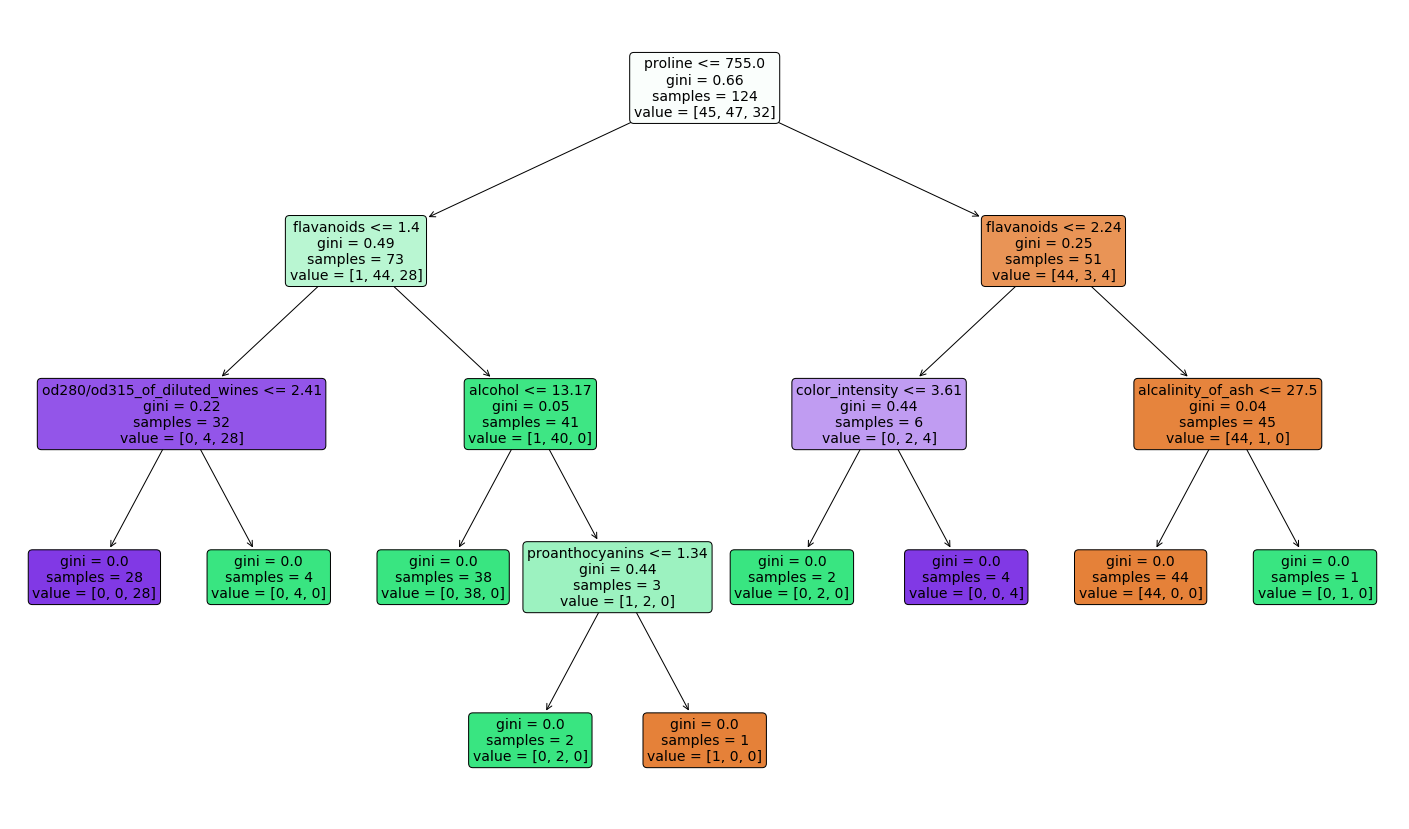

In [75]:
plt.figure(figsize=(25, 15))
plot_tree(model, feature_names=data['feature_names'], filled=True, rounded=True, precision=2, fontsize=14)
plt.show()

The displayed model shows there are some nodes with only 1 sample leading to the classification. It is possible these examples are leading to overfitting of the training data and the model could potentially be improved by setting the minimum number of samples for a leaf to avoid this outcome.

# Random Forest #

A random forest is an ensemble learning method. An ensemble learning method creates multiple models for performing the given task (classification, regression). In the case of a random forest, it creates multiple decision trees. The model will then output the class predicted by majority "vote" of the trees.

The models are created from random samples (with replacement) of the data set, a method known as bootstrap aggregating. 

In [77]:
# import packages

from sklearn import datasets, model_selection, metrics
from sklearn.ensemble import RandomForestClassifier

### Data Import ###

For this example, I'll use the same wine data set as before. I'll split it into a training and testing set only. Instead of performing parameter searching, I'll use the max depth of 5 as used in the decision tree model above.

In [78]:
data = datasets.load_wine()
X = data['data']
Y = data['target']

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y, train_size=0.7)

### Model Construction ###

As mentioned, I'll construct the random forest with the same max depth as used in the decision classifier. This value was found to be generally good for this data set previously and will be good enough to illustrate the implementation of the random forest on the same data set. I'll use the default values for the number of trees and number of samples to draw for bootstrapping as well. For the latter, this will be the size of the data set, though recall the sampling is conducted with replacement, so it is not necessarily reconstructing the exact data set each time.

In [79]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

### Analysis of Results ###

Similar to the above, I'll report the overall accuracy of the model and explore the results of the confusion matrix.

In [80]:
acc = model.score(X_test, Y_test)
print('Accuracy:', acc)
print()

cmatrix = metrics.confusion_matrix(Y_test, Y_pred)
print(cmatrix)

Accuracy: 0.9814814814814815

[[16  0  0]
 [ 0 24  1]
 [ 0  0 13]]


The results show a much higher accuracy on the random forest classifier than the decision tree model. This is reflected as well in the confusion matrix, where we see only one misclassification of a class 1 data point being predicted as part of class 2.

This demonstrates the usefulnes of ensemble learning methods. Since they use results from multiple, slightly different versions of the model to perform the classification task, they can result in a more accurate overall model.